# Twitter user classification
# Topic modeling and GloVe vectors in gensim
<img src="images/gensim.png">

We will be developing a toy machine learning pipeline which can classify a twitter user into one of 8 categories based on the user's tweets.
Following are the concepts we'll be exploring:
- Bag of words
- TF-IDF
- Visualizing our data with topic models.
- LDA model tuning with topic coherence
- Dimensionality reduction with topic models
- GloVe vectors for classification

Through this tutorial, you will become comfortable with the gensim API and also learn how to do topic modeling effectively using gensim. There could be better ways of tuning certain topic models using other techniques however we will be using the newly released topic coherence pipeline implemented in gensim inspired from [this](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) paper by Roeder et al.
### Requirements
- [OPTIONAL] [python-twitter](https://python-twitter.readthedocs.io/en/latest/) (only for final function)
- [Pre-trained stanford GloVe vectors for twitter](http://nlp.stanford.edu/data/glove.twitter.27B.zip)
- gensim (latest development version preferred)
- [OPTIONAL] [twitter app authentication](http://iag.me/socialmedia/how-to-create-a-twitter-app-in-8-easy-steps/) and hence a twitter account (only for final function where we'll do real-time classification) 
- scikit-learn
- pandas
- numpy
- nltk with english stopwords
-  At least 4 GB RAM preferred. Can use the smaller GloVe vector files if RAM is an issue as there are multiple GloVe vector files available.

### Dataset
I've already built a mini-dataset consisting of a `category->handle->tweets` mapping however this is just a toy dataset. A production level twitter classifier will most likely have many more categories with a lot more handles.

In [1]:
try:
    import twitter
except ImportError:
    print("python-twitter not installed. Will not be able to do real-time classification")
import pickle
import credentials  # You'll have to fill in the credentials in the credentials file here

from pprint import pprint

In [120]:
api = twitter.Api(**credentials.creds_dict)

### Creating and exploring our dataset

### Creating the dataset

I had created a function to get tweets category-wise to avoid rate limiting problems.

I had added all the handles I could think of in one category and then gathered the tweets. Not the best way to go about it! To add new handles to a category, simply use `api.GetUserTimeline(screen_name=handle)` and add that under the relevant category with the handle

We can just load the pre-created pickle for now

In [5]:
pycon_dict = pickle.load(open("data/pycon_dict.pkl", "rb"))

### Exploring the dataset

Let's see which are the categories in the dictionary

In [6]:
pycon_dict.keys()

[u'Tech',
 u'Business & CEOs',
 u'Entertainment',
 'Science',
 u'Fashion, Travel & Lifestyle',
 u'Sports',
 u'Music',
 u'Politics']

Each category contains a mix of benchmark twitter handles which can be magazines/channels and personalities tweeting about that category

In [7]:
pycon_dict['Music'].keys()

['GojiraMusic',
 u'thedailyswarm',
 u'soundofthecity',
 u'BLABBERMOUTHNET',
 'davidguetta',
 u'mtvmusic',
 u'billboard',
 u'NME',
 'frenchmusicuk',
 'justinbieber',
 u'HipHopDX',
 'arrahman',
 'ironmaiden',
 u'coldplay',
 'taylorswift13',
 u'stereogum',
 u'coslive',
 u'resetin',
 u'hypem',
 u'RollingStone',
 u'SPINmagazine']

All categories have almost the same number of handles

In [8]:
print(['{}-{}'.format(cat, len(pycon_dict[cat].keys())) for cat in pycon_dict.keys()])

['Tech-20', 'Business & CEOs-20', 'Entertainment-18', 'Science-18', 'Fashion, Travel & Lifestyle-19', 'Sports-19', 'Music-21', 'Politics-17']


### Time for manual inspection
This is an important step while dealing with textual data

What do tweets from different categories look like? Can we spot any patterns or signals through manual inspection?

In [9]:
pycon_dict['Business & CEOs']['XinfuCEOs'][:5]

[Status(ID=764030547039354880, ScreenName=XinfuCEOs, Created=Fri Aug 12 09:27:32 +0000 2016, Text=u'Trying and failing is better than not trying at all. Think outside the box and take your company to a new level! https://t.co/3EJVNLWaS4'),
 Status(ID=763657953912221696, ScreenName=XinfuCEOs, Created=Thu Aug 11 08:46:58 +0000 2016, Text=u'Kalanick #CEObestpractice -have cool disruptive projects going alongside tough challenges, to keep you invigorated! https://t.co/c6UQMnCsjX'),
 Status(ID=761131367098974208, ScreenName=XinfuCEOs, Created=Thu Aug 04 09:27:13 +0000 2016, Text=u'Great CEOs need to be questioning the big things as Page does. Does your CEO do this? https://t.co/sJtzJoU5kf'),
 Status(ID=760382249779036160, ScreenName=XinfuCEOs, Created=Tue Aug 02 07:50:30 +0000 2016, Text=u'Read my new post on LinkedIn: "CEOs fear September Brexit bump" https://t.co/ZjXJdzzAs3 by @SteveTappin on @LinkedIn'),
 Status(ID=757895380306694144, ScreenName=XinfuCEOs, Created=Tue Jul 26 11:08:34 +00

In [10]:
pycon_dict['Music']['mtvmusic'][:5]

[Status(ID=775665405897674752, ScreenName=MTVMusic, Created=Tue Sep 13 12:00:18 +0000 2016, Text=u'Tropical House Lives On At Electric Zoo https://t.co/lUpLIpWg3H by @_davidturner_: https://t.co/NI3bq2k8am'),
 Status(ID=775537028712759296, ScreenName=MTVMusic, Created=Tue Sep 13 03:30:11 +0000 2016, Text=u'Lady Gaga surprised a London bar with a \u2018Perfect Illusion\u2019 performance: https://t.co/qg2NLFmz4X https://t.co/N21EN56xXm'),
 Status(ID=775514431086325760, ScreenName=MTVMusic, Created=Tue Sep 13 02:00:23 +0000 2016, Text=u'Lil Wayne is leaving Cash Money on a grateful note: https://t.co/QyRbVc3oPe https://t.co/Pky9gbnhMS'),
 Status(ID=775509333786460161, ScreenName=MTVMusic, Created=Tue Sep 13 01:40:08 +0000 2016, Text=u'Drake really can\u2019t say no to any opportunity to gush about Rihanna: https://t.co/zSuxnIlDGn https://t.co/RIneFgXBzv'),
 Status(ID=775479379782692864, ScreenName=MTVMusic, Created=Mon Sep 12 23:41:06 +0000 2016, Text=u'Tyler, The Creator and Earl Sweatsh

In [11]:
pycon_dict['Science']['NASA'][:5]

[Status(ID=775500179663360000, ScreenName=NASA, Created=Tue Sep 13 01:03:45 +0000 2016, Text=u'RT @NASAEarth: Visualizing the Warmest August in 136 Years https://t.co/PSjA2NfYem Data via @NASAGISS #NASA #climate https://t.co/DIk8z7Zodj'),
 Status(ID=775482690678259712, ScreenName=NASA, Created=Mon Sep 12 23:54:15 +0000 2016, Text=u'Auroras are seen moving to the rhythms of Earth\u2019s magnetic field by our THEMIS mission: https://t.co/cYtWB2VQNf https://t.co/zM1ih9shcF'),
 Status(ID=775469883832274944, ScreenName=NASA, Created=Mon Sep 12 23:03:22 +0000 2016, Text=u'August 2016 was warmest August in 136 years of modern records, say scientists at @NASAGISS: https://t.co/8uc0XmeCgB https://t.co/rESsBM4OeO'),
 Status(ID=775453525757333506, ScreenName=NASA, Created=Mon Sep 12 21:58:22 +0000 2016, Text=u'Join @NASAEarth on @Facebook at 6:30pm ET to learn how to document clouds from our new app: https://t.co/iDF2MYyxQC https://t.co/C8bYp2pgs8'),
 Status(ID=775431070191935488, ScreenName=NASA

Manual inspection surely reveals some signal. We can see a marked difference between how typical tweets in the business, music and science category look like. Given some tweets from a category we should be able to classify accurately. The human mind is a pretty good classifier :)

### Creating training and test sets

In [12]:
import numpy as np
import pandas as pd

We'll be using 90% of the tweets (for each profile) for training and 10% for testing, i.e. a 90-10 split as mentioned in [this](http://snap.stanford.edu/soma2010/papers/soma2010_12.pdf) paper by Davison et al. Cross validation can and should be done however since our dataset is small we'll be skipping it for now.

In [13]:
columns = ['message', 'category']

A [two-way](http://stackoverflow.com/questions/1456373/two-way-reverse-map) dictionary will help in creating a category mapping. I've already done this and we'll be using that mapping so that all of us have a uniform mapping

In [14]:
categories_map = {0: u'Business & CEOs',
                  1: u'Music',
                  2: u'Entertainment',
                  3: u'Fashion, Travel & Lifestyle',
                  4: u'Sports',
                  5: u'Tech',
                  6: u'Politics',
                  7: u'Science',
                  u'Business & CEOs': 0,
                  u'Entertainment': 2,
                  u'Fashion, Travel & Lifestyle': 3,
                  u'Music': 1,
                  u'Politics': 6,
                  u'Science': 7,
                  u'Sports': 4,
                  u'Tech': 5}

In [15]:
def get_dataframes(pycon_dict):
    """
    Function to get train and test dataframes (without any preprocessing).
    
    Parameters:
    ----------
    pycon_dict: The twitter user dictionary being used.
    
    Returns:
    -------
    train, test: Train and test dataframes.
    """
    train = pd.DataFrame(columns=columns)
    test = pd.DataFrame(columns=columns)
    
    for category in pycon_dict:
        for entity in pycon_dict[category]:
            train_texts = []
            test_texts = []
            num_texts = len(pycon_dict[category][entity])  # To get number of tweets
            train_indices = np.random.choice(num_texts, int(0.9 * num_texts), replace=False)  # Random selection
            test_indices = [i for i in range(num_texts) if i not in train_indices]  # Rest go into test set
            train_texts.extend(pycon_dict[category][entity][i].text for i in train_indices)  # Add to train texts
            test_texts.extend(pycon_dict[category][entity][i].text for i in test_indices)  # Add to test texts
            #### Create train dataframe ####
            train_texts = ' '.join(train_texts)
            df_train = pd.DataFrame([[train_texts, categories_map[category]]], columns=columns)
            train = train.append(df_train, ignore_index=True)
            #### Create test dataframe ####
            test_texts = ' '.join(test_texts)
            df_test = pd.DataFrame([[test_texts, categories_map[category]]], columns=columns)
            test = test.append(df_test, ignore_index=True)
            
    return train, test

### Preprocessing our data. Remember: Garbage in, garbage out
    NLP is 80% preprocessing
                        - Lev Konstantinovskiy
Preprocessing is probably the single most important step in producing good topic models which give human interpretable topics. Do take some time to study the preprocessor well because we'll be using the same preprocessor for the tasks later on for classification using Bag of words and TF-IDF

In [16]:
import re
from nltk.corpus import stopwords  # for using english stopwords
from gensim.models.phrases import Phrases
from gensim.utils import deaccent, decode_htmlentities, lemmatize

/home/devashish/miniconda2/lib/python2.7/site-packages/numpy/lib/utils.py:99: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  warnings.warn(depdoc, DeprecationWarning)


In [17]:
stops = stopwords.words('english')

Following are the steps we'll be taking to preprocess a user profile, i.e. a space seperated collection of at most 200 most recent tweets of the profile:
1. Decode html entities. eg. "AT`&`amp;T" will become "AT&T"
2. Deaccent. Eg:
    ```
    >>> deaccent("Šéf chomutovských komunistů dostal poštou bílý prášek")
    u'Sef chomutovskych komunistu dostal postou bily prasek'
    ```
3. Remove links.
4. Remove any user mentions (__@name__). This could maybe be skipped as user mentions can also provide signal. However we'll be removing them for this tutorial.
5. Lemmatize and remove stopwords. Lemmatization is preferred over stemming here because lemmatization retains readability of the words which is important in our case.
6. We will only pick nouns here since they contribute the most to the signal

In [18]:
def preprocess_text(tweet):
    """
    Function to process an aggregated user profile. This does the following:
    1. Decode html entities. eg. "AT&amp;T" will become "AT&T"
    2. Deaccent
    3. Remove links.
    4. Remove any user mentions (@name).
    5. Lemmatize and remove stopwords.
    
    Parameters:
    ----------
    text : String. If train_texts is a list of tweets, ' '.join and pass
    
    Returns:
    -------
    text : preprocessed (tokenized) tweet.
    """
    tweet = decode_htmlentities(tweet)
    tweet = deaccent(tweet)
    tweet = tweet.encode('ascii', 'ignore')  # To prevent UnicodeDecodeErrors later on
    tweet = re.sub(r'http\S+', '', tweet)  # Step 3
    tweet = re.sub(r'@\w+', '', tweet)  # Step 4
    tweet = tweet.split()
    tweet = lemmatize(' '.join(tweet), re.compile('(NN)'), stopwords=stops, min_length=3, max_length=15)
    tweet = [word.split('/')[0] for word in tweet]
    return tweet

In [19]:
preprocess_text('Tropical House Lives On At Electric Zoo :) https://t.co/lUpLIpWg3H by @_davidturner_: https://t.co/NI3bq2k8am')

['house', 'zoo']

### Preprocessing our train, test dataframes

In [20]:
train, test = get_dataframes(pycon_dict)

Let's see what our function does

In [24]:
preprocess_text(train['message'][0])[100:120]

['sea',
 'friday',
 'cnet',
 'news',
 'alexa',
 'iphone',
 'event',
 'start',
 'time',
 'stream',
 'mark',
 'zuckerberg',
 'system',
 'toast',
 'phone',
 'refrigerator',
 'change',
 'industry',
 'sprint',
 'jungle']

Apply function to all tweets in our training dataframe

In [23]:
train_texts = train['message'].apply(preprocess_text)

Bigram collocation can detect words which frequently occur together and know whether they are in fact the same entity

In [25]:
bigram = Phrases(train_texts)  # For collocation detection

In [26]:
bigram['hillary', 'clinton']

[u'hillary_clinton']

As we can see, the bigram collocation has figured out that the words 'hillary' and 'clinton' refer to the same entity that is 'Hillary Clinton' the politician.

In [27]:
train_texts = [bigram[profile] for profile in train_texts]

You can notice the other bigram collocations below for the sports category

In [29]:
train_texts[100][:20]

[u'zlatan',
 u'ibrahimovic',
 u'paul_pogba',
 u'critic',
 u'word',
 u'report',
 u'diego_costa',
 u'rescue',
 u'point',
 u'antonio',
 u'side',
 u'goal',
 u'aston_villa',
 u'nottingham_forest',
 u'mccormack',
 u'sky_sport',
 u'suarez',
 u'game',
 u'barcelona',
 u'star']

In [30]:
len(train_texts)

152

In [31]:
test_texts = test['message'].apply(preprocess_text)
test_texts = [bigram[message] for message in test_texts]

# Set up helper functions for classification evaluation
It is important to choose an evaluation metric to compare our models. We will choose accuracy here however other metrics such as F-Measure can also be used depending on the use-case of the model.

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib import pyplot as plt

%matplotlib inline

In [33]:
my_tags = pycon_dict.keys()

In [34]:
categories = train['category']

In [38]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [39]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [40]:
def most_influential_words(clf, vectorizer, category_index=0, num_words=10):
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(clf.coef_[category_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]    

# Let's build our first classification model
__Note__: We will be using `LogisticRegression` throughout this tutorial. I would also encourage you to try out the new `MLPClassifier` released as part of `scikit-learn 0.18`. This uses a neural network for classification and is a very powerful tool for learning complex non-linear functions.

# Bag of words with LogisticRegression
It sometimes important in any machine learning task to set up a baseline model in as little time as possible. This can help us gauge how much better our ideal model should be. It can also help us find out the areas where we need to work on to make our model better. Would bringing in more data help? Would making our preprocessing better help? Such questions can be answered more accurately. There are many ways to find out the answers to these questions however they lie of of scope for this tutorial

We will be using bag of words first as it is the simplest document feature which is available. It is simply a word occurence matrix across all the words and all the documents.

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

We'll only take the most frequent 5000 features.

In [42]:
count_vectorizer = CountVectorizer(max_features=5000)

In [43]:
train_count_features = count_vectorizer.fit_transform(' '.join(text) for text in train_texts)

In [44]:
clf_count = LogisticRegression()

In [45]:
clf_count = clf_count.fit(train_count_features, categories)

In [46]:
test_count_features = count_vectorizer.transform(' '.join(text) for text in test_texts)

In [47]:
predictions = clf_count.predict(test_count_features)

accuracy 0.940789473684
confusion matrix
 [[16  0  0  0  1  2  0  1]
 [ 0 21  0  0  0  0  0  0]
 [ 0  2 16  0  0  0  0  0]
 [ 0  0  1 18  0  0  0  0]
 [ 0  0  1  0 18  0  0  0]
 [ 1  0  0  0  0 19  0  0]
 [ 0  0  0  0  0  0 17  0]
 [ 0  0  0  0  0  0  0 18]]
(row=expected, col=predicted)


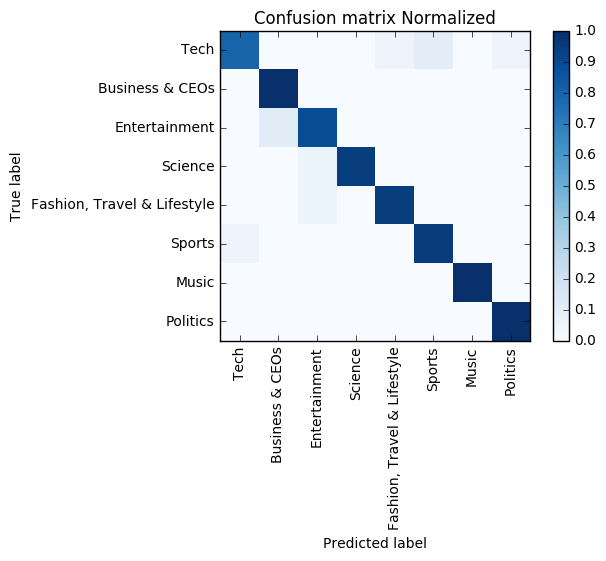

In [48]:
evaluate_prediction(predictions, test['category'])

Greater than 90% accuracy is great for our first model!

__Why did it work__? Twitter benchmark users of any particular category tweet in a very distinct way. As we saw above, users in the "Music" category are more likely to use words like "performance" or "album" more. Similarly users in the "Politics" category tend to use words like "policy" more. Bag of words can catch this quite brilliantly! We can see evidence of this below.

In [49]:
most_influential_words(clf_count, count_vectorizer, category_index=7)  # Top words for science category

[u'science',
 u'earth',
 u'scientist',
 u'space',
 u'alien',
 u'study',
 u'dystrophaeus_fossiltime',
 u'bone',
 u'book',
 u'astronaut']

# [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) with LogisticRegression
This is a slightly more advanced method than bag of words. Bag of words needs good preprocessing more than TF-IDF as it is a raw count. However TF-IDF can reduce the weight for highly occuring terms such as 'the' by dividing by normalizing it with the number of documents it occurs in.

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [51]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

In [52]:
train_tfidf_features = tfidf_vectorizer.fit_transform(' '.join(text) for text in train_texts)

In [53]:
clf_tfidf = LogisticRegression()

In [54]:
clf_tfidf = clf_tfidf.fit(train_tfidf_features, categories)

In [55]:
test_tfidf_features = tfidf_vectorizer.transform(' '.join(text) for text in test_texts)

In [56]:
predictions = clf_tfidf.predict(test_tfidf_features)

accuracy 0.934210526316
confusion matrix
 [[15  0  0  0  0  4  0  1]
 [ 0 21  0  0  0  0  0  0]
 [ 0  0 18  0  0  0  0  0]
 [ 1  0  0 18  0  0  0  0]
 [ 0  0  0  0 19  0  0  0]
 [ 2  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0 17  0]
 [ 1  1  0  0  0  0  0 16]]
(row=expected, col=predicted)


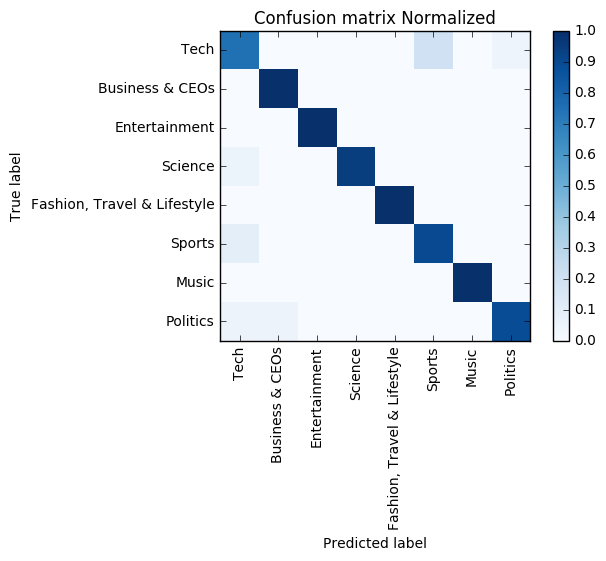

In [57]:
evaluate_prediction(predictions, test['category'])

__Exercise__: What are the most influential words from this model in the politics category?

Even this model gives us a wonderful accuracy!

__However let's try some more methods__. First we will do some topic modeling. After all the package we will be using is called "Gensim-Topic Modeling for Humans"! Topic modeling can help find hidden structure in our data and thus is very useful in visualizing our dataset. It can in turn also be used for classification and dimensionality reduction among many of it's other uses.

# Let's do some topic modelling
Essentially we're trying to find out the topics of the tweets which the user is tweeting about. Since topic models come up with topic distributions, they can probably help us in this task.

Let's see if we can use topic models to find some hidden structure in our data first!

### Setting up our standard gensim corpus
You can refer to the short tutorial [here](https://radimrehurek.com/gensim/tut1.html) for reference as to how a standard gensim corpus is set. 

In [58]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

In [59]:
dictionary = Dictionary(train_texts)

In [60]:
print(dictionary)

Dictionary(16300 unique tokens: [u'jaesuk', u'sermersheim', u'headband', u'degenere', u'jetline']...)


In [61]:
corpus = [dictionary.doc2bow(text) for text in train_texts]

### [LSI](https://radimrehurek.com/gensim/models/lsimodel.html) (Latent Semantic Indexing)
LSI uses Singular Value Decomposition (SVD) for topic modeling. It can rank topics automatically but needs the `num_topics` parameter to be entered for the number of latent dimensions requested. There is currently an open [issue](https://github.com/RaRe-Technologies/gensim/issues/28) in gensim where an automatic number of topics "chooser" has been proposed.

In [62]:
from gensim.models import LsiModel

In [63]:
lsim = LsiModel(corpus=corpus, num_topics=100, id2word=dictionary)

In [64]:
lsim.show_topics(num_topics=10)

[(0,
  u'0.483*"travel" + 0.235*"time" + 0.229*"thank" + 0.207*"day" + 0.192*"world" + 0.192*"today" + 0.180*"year" + 0.159*"france" + 0.149*"video" + 0.145*"week"'),
 (1,
  u'0.823*"travel" + -0.149*"today" + -0.147*"thank" + -0.124*"year" + -0.122*"day" + -0.112*"time" + -0.103*"video" + -0.096*"person" + -0.093*"trump" + -0.083*"week"'),
 (2,
  u'-0.875*"france" + -0.264*"paris" + 0.166*"travel" + -0.155*"france_france" + 0.087*"thank" + -0.063*"debate" + -0.059*"wine" + -0.058*"ban" + 0.057*"time" + -0.056*"food"'),
 (3,
  u'0.461*"ceo_medium" + 0.454*"number_ceo" + 0.454*"congratulation_number" + 0.420*"congratulation_ceo" + 0.399*"medium_socialceos" + 0.124*"ceo" + 0.055*"ceos_medium" + 0.034*"medium_congratulation" + 0.034*"ceo_number" + 0.034*"company"'),
 (4,
  u'-0.918*"recipe" + 0.141*"trump" + -0.116*"cheese" + -0.083*"gbbo" + -0.076*"chef" + -0.065*"pizza" + -0.063*"recipe_chicken" + -0.061*"cake" + -0.055*"article" + -0.053*"chocolate"'),
 (5,
  u'0.535*"trump" + 0.354*"i

In [65]:
lsimtopics = lsim.show_topics(formatted=False)

### [HDP](https://radimrehurek.com/gensim/models/hdpmodel.html) (Hierarchical Dirichlet Process)
An HDP model is fully unsupervised. It can also determine the ideal number of topics through posterior inference. This property of HDP is particularly useful when in the "online" mode where the number of documents keep streaming and hence the number of topics becomes hard to determine before-hand as in LDA.

In [66]:
from gensim.models import HdpModel

In [67]:
hdpm = HdpModel(corpus=corpus, id2word=dictionary)

In [68]:
hdpm.show_topics()

[u'topic 0: 0.006*india + 0.004*time + 0.004*year + 0.004*apple + 0.004*china + 0.003*market + 0.003*world + 0.003*today + 0.003*chef + 0.003*week + 0.002*iphone + 0.002*google + 0.002*tech + 0.002*day + 0.002*cheersmate + 0.002*rate + 0.002*food + 0.002*bank + 0.002*samsung + 0.002*twitter',
 u'topic 1: 0.008*thank + 0.007*travel + 0.005*time + 0.004*today + 0.003*day + 0.003*person + 0.003*week + 0.003*year + 0.003*video + 0.003*way + 0.003*thing + 0.002*life + 0.002*world + 0.002*photo + 0.002*scientist + 0.002*kid + 0.002*story + 0.002*love + 0.002*man + 0.002*woman',
 u'topic 2: 0.011*france + 0.004*day + 0.004*hillary_clinton + 0.004*twitter + 0.003*trump + 0.003*travel + 0.003*paris + 0.003*france_france + 0.002*world + 0.002*thank + 0.002*linux + 0.002*tweet + 0.002*person + 0.002*window + 0.002*earth + 0.002*today + 0.002*driver + 0.002*rio + 0.002*support + 0.002*week',
 u'topic 3: 0.006*thank + 0.004*trump + 0.004*year + 0.003*person + 0.003*week + 0.003*world + 0.003*day + 

HDP surely comes up with better, more human interpretable topics as we can see. There are topics which clearly talk about sports, others which only have words related to politics or some which relate to travel. As we saw above in LSI, the topics were a bit mixed up. HDP doesn't seem to mix it up as much.

In [69]:
hdpmtopics = hdpm.show_topics(num_topics=-1, num_words=10, formatted=False)

### [LDA](https://radimrehurek.com/gensim/models/ldamodel.html) (Latent Dirichlet Allocation)
This is one the most popular topic modeling algorithms today. It is a generative model in that it assumes each document is a mixture of topics and in turn, each topic is a mixture of words. To understand it better you can watch [this](https://www.youtube.com/watch?v=DDq3OVp9dNA) lecture by David Blei.
<img src="images/blei_news.png">

In [70]:
ldam = LdaModel(corpus=corpus, num_topics=100, id2word=dictionary)

In [71]:
ldam.show_topics()

[(4,
  u'0.008*year + 0.007*sciart + 0.005*today + 0.005*world + 0.004*fossil + 0.004*fish + 0.004*earth + 0.004*tonight + 0.004*day + 0.004*thing'),
 (44,
  u'0.009*thank + 0.009*video + 0.008*time + 0.007*tonight + 0.007*today + 0.006*world + 0.006*day + 0.006*year + 0.005*thing + 0.004*show'),
 (67,
  u'0.007*watch + 0.006*france + 0.005*goal + 0.005*world + 0.004*debate + 0.004*sky_sport + 0.004*thank + 0.003*year + 0.003*day + 0.003*today'),
 (36,
  u'0.010*video + 0.009*time + 0.008*today + 0.008*thank + 0.008*year + 0.007*week + 0.006*day + 0.006*album + 0.005*life + 0.005*world'),
 (98,
  u'0.011*thank + 0.009*cpp + 0.009*day + 0.008*today + 0.008*earth + 0.008*space + 0.006*time + 0.005*year + 0.005*mission + 0.005*sciart'),
 (83,
  u'0.008*time + 0.005*year + 0.005*day + 0.005*champion + 0.005*world + 0.005*today + 0.004*tonight + 0.004*ceo_medium + 0.004*thank + 0.003*season'),
 (51,
  u'0.008*time + 0.007*thank + 0.007*day + 0.006*india + 0.006*year + 0.005*science + 0.005*

`LdaModel` also comes up with decent topics. We can decipher some topics by the word distributions.

In [72]:
ldamtopics = ldam.show_topics(num_topics=-1, formatted=False)

# Topic Coherence
<img src='images/pipeline.png'>
Topic coherence is a way to quantify the human interpretability of the topics. Simply enter the __topics 't'__ and you get __coherence value 'c'__ as the output! The topic coherence pipeline recently got merged into gensim which was based on [this](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) paper by Roeder et al.

This is a great way to compare individual topics and can be extended to comparing different topic models as well. We will be doing this later on in this tutorial.

To know more about topic coherence you can read my blog [here](https://rare-technologies.com/what-is-topic-coherence/) where I have to tried to give an introductory explanation of how topic coherence works.

### Finding optimal number of topics
As we saw above, `LdaModel` requires the number of topics to be entered for fitting it. This is one of the problem of LDA as knowing the number of topics beforehand can be a challenging task especially in an online setting. Traditionally, perplexity has been used to find out the optimum number of topics. We will be using topic coherence instead. The logic is pretty simple in that: "Let's select the number of topics which we can understand easily".

In [73]:
import operator
from gensim.models import CoherenceModel

In [74]:
BASE = 6  # base number of topics for graph evaluation

In [75]:
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    """
    if limit < BASE:
        raise ValueError("Please enter limit > %d. You entered %d" % (BASE, limit))
    c_v = []
    lm_list = []
    for num_topics in range(BASE, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(6, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

We iteratively train LdaModels for different number of topics ranging from 6 to 15. Topics lesser than 6 might not make sense however we should be getting the ideal value around 8 as the number of categories we have are 8.

__Warning__: Can take quite long to compute. If you want to reduce the amount of time taken here, you can reduce the limit or better, change the coherence algorithm to `u_mass` instead. However it has been experimentally proven that `c_v` correlates best with human interpretation.

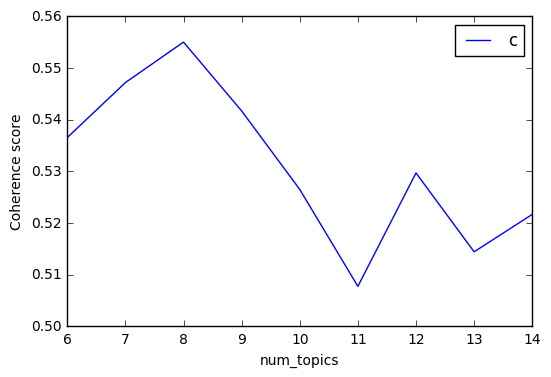

CPU times: user 2min 9s, sys: 328 ms, total: 2min 9s
Wall time: 2min 10s


In [76]:
%%time
lm_list, c_v = evaluate_graph(dictionary, corpus, train_texts, 15)

In [77]:
ldam_tc = lm_list[np.argmax(c_v)]  # Select the LdaModel corresponding to the best coherence value

In [78]:
ldam_tc.show_topics(num_topics=-1)

[(0,
  u'0.008*video + 0.006*time + 0.006*day + 0.005*week + 0.005*year + 0.005*today + 0.005*thank + 0.004*travel + 0.004*world + 0.004*iphone'),
 (1,
  u'0.006*year + 0.006*time + 0.006*thank + 0.005*day + 0.005*video + 0.004*world + 0.004*today + 0.004*tonight + 0.004*person + 0.003*way'),
 (2,
  u'0.009*day + 0.007*time + 0.006*travel + 0.005*thank + 0.005*year + 0.004*video + 0.004*today + 0.003*person + 0.003*week + 0.003*man'),
 (3,
  u'0.013*travel + 0.010*thank + 0.008*france + 0.007*time + 0.005*day + 0.005*year + 0.005*world + 0.004*week + 0.004*today + 0.004*person'),
 (4,
  u'0.009*today + 0.008*time + 0.006*thank + 0.006*day + 0.006*world + 0.005*travel + 0.005*year + 0.005*week + 0.004*person + 0.004*thing'),
 (5,
  u'0.009*recipe + 0.007*time + 0.006*today + 0.005*year + 0.005*world + 0.005*day + 0.004*video + 0.004*week + 0.004*person + 0.004*thank'),
 (6,
  u'0.008*thank + 0.007*today + 0.006*day + 0.006*year + 0.006*time + 0.005*trump + 0.005*week + 0.005*world + 0.0

In [79]:
ldam_tctopics = ldam_tc.show_topics(num_topics=-1, formatted=False)

### LDA as LSI
As we saw above, LSI can automatically rank topics. We can actually do the same with LDA also by making it work with the topic coherence pipeline. We rank individual topics based on their human interpretability.

We will be going one step further here and making a new LDA model by using only the best topics from the first LDA model. An "LDA migration" of sorts! This can be done by selecting the `alphas` and `betas` corresponding to only the best topics from the first LDA model and transferring them onto the new model.

In [80]:
def ret_top_model(num_topics):
    """
    Since LDAmodel is a probabilistic model, it comes up different topics each time we run it. To control the
    quality of the topic model we produce, we can create another topic model from only the most coherent n topics
    from the LDAmodel.
    
    Parameters:
    ----------
    num_topics: Number of top topics for new LdaModel.
    
    Returns:
    -------
    refined_lm: Final evaluated topic model
    top_topics: ranked topics in decreasing order. List of tuples
    """
    lm = LdaModel(corpus=corpus, id2word=dictionary)
    coherence_values = {}
    doc = []
    for n, topic in lm.show_topics(num_topics=-1, formatted=False):
        topic = [word for word, _ in topic]
        cm = CoherenceModel(topics=[topic], texts=train_texts, dictionary=dictionary)
        coherence_values[n] = cm.get_coherence()
    top_topics = sorted(coherence_values.items(), key=operator.itemgetter(1), reverse=True)[:num_topics]
    top_topics = [t for t, c in top_topics]
    alpha = lm.alpha[top_topics]
    beta = lm.expElogbeta[top_topics, :]
    refined_lm = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha)
    refined_lm.expElogbeta[:] = beta
    return refined_lm

__Warning__: Can take some time to run

In [81]:
%%time
lda_lsim = ret_top_model(BASE + np.argmax(c_v))  # Using the value we found above

CPU times: user 1min 45s, sys: 1min 30s, total: 3min 15s
Wall time: 1min 33s


In [82]:
lda_lsim.show_topics(-1)

[(0,
  u'0.007*thank + 0.006*year + 0.006*france + 0.005*time + 0.005*person + 0.004*day + 0.004*today + 0.004*travel + 0.004*india + 0.003*week'),
 (1,
  u'0.009*day + 0.008*time + 0.007*today + 0.006*thank + 0.006*world + 0.004*week + 0.004*video + 0.004*recipe + 0.004*year + 0.003*tonight'),
 (2,
  u'0.006*time + 0.006*year + 0.005*travel + 0.005*thank + 0.004*world + 0.004*trump + 0.004*video + 0.004*day + 0.004*week + 0.004*today'),
 (3,
  u'0.008*thank + 0.006*time + 0.006*year + 0.005*today + 0.005*video + 0.005*day + 0.005*world + 0.004*person + 0.004*way + 0.003*thing'),
 (4,
  u'0.014*travel + 0.007*time + 0.006*today + 0.006*thank + 0.005*day + 0.005*week + 0.005*world + 0.004*year + 0.004*trump + 0.003*tonight'),
 (5,
  u'0.008*time + 0.007*day + 0.007*thank + 0.006*week + 0.006*today + 0.005*year + 0.004*travel + 0.004*person + 0.004*world + 0.004*video'),
 (6,
  u'0.007*year + 0.006*today + 0.006*france + 0.005*day + 0.005*time + 0.004*world + 0.004*thank + 0.004*week + 0

HDP model still seems like the best one yet....

In [83]:
lda_lsimtopics = lda_lsim.show_topics(num_topics=-1, formatted=False)

Let's transfer out HDP model into an LDA model. We can do these by copying over the corresponding alphas and betas into the LDA model. This will also help us calculate topic inferences easily if this turns out to be the best LDA model so far.

In [84]:
alpha, beta = hdpm.hdp_to_lda()
num_topics = len(hdpmtopics)

In [85]:
%%time
lda_hdp = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha)
lda_hdp.expElogbeta[:] = beta

CPU times: user 1min 57s, sys: 2min 29s, total: 4min 27s
Wall time: 1min 45s


### Evaluating all topic models
Finally, we will be using the topic coherence pipeline to compare all the topic models we have created so far. Till now we have only been qualitatively comparing the models. The topic coherence pipeline allows us to quantitatively compare the different topic models. 

In [86]:
lsimtopics = [[word for word, prob in topic] for topicid, topic in lsimtopics]
hdpmtopics = [[word for word, prob in topic] for topicid, topic in hdpmtopics]
ldamtopics = [[word for word, prob in topic] for topicid, topic in ldamtopics]
ldam_tctopics = [[word for word, prob in topic] for topicid, topic in ldam_tctopics]
lda_lsimtopics = [[word for word, prob in topic] for topicid, topic in lda_lsimtopics]

In [87]:
%%time
lsi_coherence = CoherenceModel(topics=lsimtopics, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
hdp_coherence = CoherenceModel(topics=hdpmtopics, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
lda_coherence = CoherenceModel(topics=ldamtopics, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
lm_coherence = CoherenceModel(topics=ldam_tctopics, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
lda_lsi_coherence = CoherenceModel(topics=lda_lsimtopics, texts=train_texts, dictionary=dictionary, window_size=110).get_coherence()
lda_hdp_coherence = CoherenceModel(model=lda_hdp, texts=train_texts, dictionary=dictionary).get_coherence()

CPU times: user 1min 34s, sys: 856 ms, total: 1min 35s
Wall time: 1min 34s


In [88]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

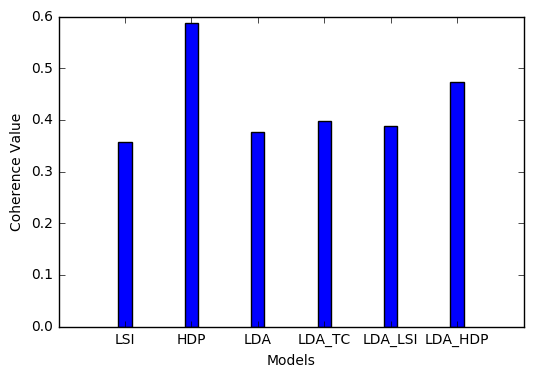

In [89]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence, lm_coherence, lda_lsi_coherence, lda_hdp_coherence],
                   ['LSI', 'HDP', 'LDA', 'LDA_TC', 'LDA_LSI', 'LDA_HDP'])

Our intuition was correct! HDP model turned out to be the best one and the transferred HDP model turned out to be the best LDA model. I would have liked our optimal topics and lda_lsi to perform better but we can be happy that it at least performs better than vanilla LDA!

__DO REMEMBER__ that these values and topic models only correspond to this dataset and can vary accross different datasets. In fact since LDA models are probabilistic, they can vary a lot across runs too! We could have done better in LDA tuning however this was a tutorial on how topic coherence in particular can be used for LDA tuning. 
I have observed that HDP models generally perform better when each `text` within `texts` has a lot of tokens. You will notice that the comparison turned out to be very different in my [news classification notebook](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/gensim_news_classification.ipynb).

We can infer topic distributions from individual word tokens

In [90]:
lda_hdp[dictionary.doc2bow(['jimmy', 'fallon', 'entertainment'])]

[(0, 0.020747190128077891),
 (1, 0.019132123096832977),
 (2, 0.016139639448699408),
 (3, 0.01466698318688031),
 (4, 0.01280826381320767),
 (5, 0.013691593304914174),
 (6, 0.011918783422575916),
 (7, 0.010239610875683031),
 (43, 0.75037037002323403)]

In [91]:
lda_hdp.show_topic(43, topn=10)

[(u'day', 0.017776982820222609),
 (u'thank', 0.017530375102726602),
 (u'today', 0.0093509429714728511),
 (u'time', 0.0091917077501350638),
 (u'video', 0.0083852904330239935),
 (u'tonight', 0.0080587858839864888),
 (u'night', 0.006174189534930808),
 (u'year', 0.0060241990951865271),
 (u'world', 0.0055886437953409024),
 (u'testimonial', 0.0042638615442785023)]

# LDA topic inference for classification
In this tutorial we will be using our best LDA model from above for inference and classification. When we use LDA for inference it gives large probabilities for some topics but negligible for the others. This is how it looks like:
<img src='images/inference.jpg'>
<center> _Image taken from Blei's video on LDA_ </center>

__This is the pipeline we're following for LDA inference classification__ (wanted to see how well I can use the pencil in gimp):
<img src='images/lda_dim_red.png'>
P, B = Preprocessing, bigram collocation

LDA = LDA model for inference

CLF = Classifier

As we can see above in the graph, LDA inference yields positive values for only some topics and negligible values for the others. We can assume them to be 0 to create our dataframe.

In [92]:
def ret_lda_features(ldamodel, texts, num_topics):
    """
    Function to return LDA inference features for texts.
    
    Parameters:
    ----------
    ldamodel: LDA model to infer docs
    texts: Texts to be inferred
    num_topics: Number of topics. Will determine columns in dataframe
    
    Returns:
    -------
    lda_features: LDA features dataframe
    """
    lda_features = pd.DataFrame()
    for message in texts:
        features = np.zeros(shape=(1, num_topics))
        inference = ldamodel[dictionary.doc2bow(message)]
        for tid, val in inference:
            features[:, tid] = val
        features = pd.DataFrame(features)
        lda_features = lda_features.append(features, ignore_index=True)
    return lda_features

In [93]:
train_lda_features = ret_lda_features(lda_hdp, train_texts, num_topics)

In [94]:
train_lda_features.shape

(152, 150)

In [95]:
train_lda_features.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.998759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.996677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
clf_lda = LogisticRegression()

In [97]:
clf_lda = clf_lda.fit(train_lda_features, categories)

In [98]:
test_lda_features = ret_lda_features(lda_hdp, test_texts, num_topics)

In [100]:
test_lda_features.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.502519,0.119401,0.000000,0.000000,0.100274,0.0,0.259029,0.010630,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.170813,0.096998,0.000000,0.000000,0.0,0.000000,0.098504,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.411321,0.028946,0.020228,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.973800,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.050534,0.348616,0.000000,0.000000,0.141288,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
predictions = clf_lda.predict(test_lda_features)

accuracy 0.638157894737
confusion matrix
 [[ 8  1  0  1  1  6  0  3]
 [ 0 18  0  1  0  0  0  2]
 [ 2  0  6  2  2  1  0  5]
 [ 0  1  1 15  0  1  0  1]
 [ 1  3  0  1 11  0  0  3]
 [ 0  0  1  0  0 18  0  1]
 [ 0  2  1  0  1  7  5  1]
 [ 0  0  0  1  0  1  0 16]]
(row=expected, col=predicted)


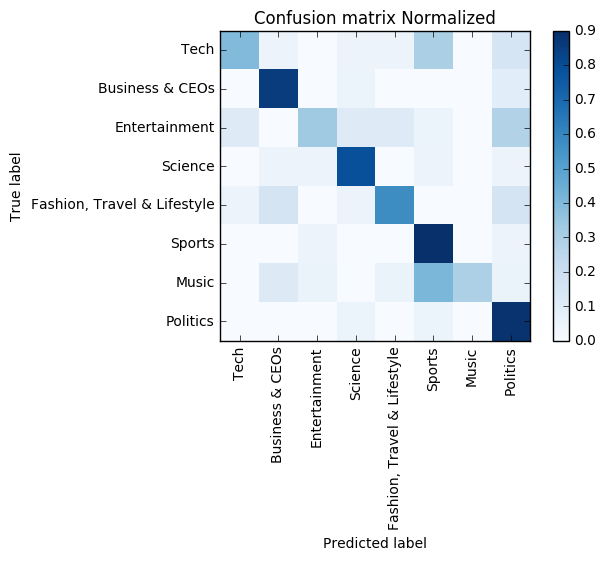

In [102]:
evaluate_prediction(predictions, test['category'])

__Exercise__: Plug in our HDP model above instead of LDA model and see what's the difference

Turns out, our TF-IDF and bag of words based models outperform this method. However no gensim tutorial is complete without word embeddings. Let's try word embeddings now!

# Word2Vec can make your heart skip a gram
Well this is not really word2vec. We're just loading pre-trained twitter GloVe vectors. GloVe produces word embeddings in a different way than word2vec. GloVe uses a count-based model to learn word embeddings whereas word2vec tries to learn a "predictive" model by using different algorithms such as skip-gram or CBOW.

We will be using twitter pre-trained GloVe vectors on twitter. We can convert them into word2vec vectors by just running [this](https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/scripts/glove2word2vec.py) script present in gensim. I have used the 50d vectors however you are free to use the larger embeddings depending on the RAM you have.

In [103]:
import gensim
import logging

from gensim.models import Word2Vec

In [104]:
wv = Word2Vec.load_word2vec_format("/home/devashish/Downloads/GloVes/wv.twitter.27B.50d.txt",
                                   binary=False)  # To use C text format
wv.init_sims(replace=True)  # To decrease RAM usage

In [105]:
wv.most_similar(positive=['arsenal'])

[(u'chelsea', 0.9786632061004639),
 (u'liverpool', 0.9681325554847717),
 (u'utd', 0.9317814707756042),
 (u'united', 0.9310426712036133),
 (u'manchester', 0.9226013422012329),
 (u'tottenham', 0.9214313626289368),
 (u'everton', 0.919910728931427),
 (u'barca', 0.9044719934463501),
 (u'swansea', 0.9019159078598022),
 (u'qpr', 0.8937806487083435)]

### For this task our preprocessing will be different
Preprocessing taken from [stanford twitter-preprocessor](http://nlp.stanford.edu/projects/glove/preprocess-twitter.rb)

In [106]:
import string

exclude = string.punctuation
exclude = re.sub('<|>', '', exclude)  # To keep our <tags> intact
exclude = set(exclude)

In [107]:
"""
preprocess-twitter.py
python preprocess-twitter.py "Some random text with #hashtags, @mentions and http://t.co/kdjfkdjf (links). :)"
Script for preprocessing tweets by Romain Paulus
with small modifications by Jeffrey Pennington
with translation to Python by Motoki Wu
Translation of Ruby script to create features for GloVe vectors for Twitter data.
http://nlp.stanford.edu/projects/glove/preprocess-twitter.rb
"""

FLAGS = re.MULTILINE | re.DOTALL

def hashtag(text):
    text = text.group()
    hashtag_body = text[1:]
    if hashtag_body.isupper():
        result = "<hashtag> {} <allcaps>".format(hashtag_body)
    else:
        result = " ".join(["<hashtag>"] + re.split(r"(?=[A-Z])", hashtag_body, flags=FLAGS))
    return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps> "


def preprocess_tweet(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"

    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", " <number> ")
    text = re_sub(r"#\S+", hashtag)
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    text = re_sub(r"([A-Z]){2,}", allcaps)
    
    text = ''.join(ch for ch in text if ch not in exclude)  # Remove punctuation

    return text.lower()

In [108]:
def g2v_tokenize_tweet(text):
    text = text.encode('ascii', 'ignore')  # Deal with UnicodeDecodeErrors
    text = preprocess_tweet(text)
    return text.split()

# Word Vector Averaging
To get a vector for a document, we simply average it's word vectors. As suggested in [this](https://www.youtube.com/watch?v=7gTjYwiaJiU) video by Mike Tamir, the word averaging results to some kind of a unique word summarizing the whole document in one word. Eg all words in a book 'A tale of two cities' would probably add up to 'class-struggle'.
<img src='images/word_avg.png'>

In [109]:
# code from "Movie plots by genre" by Lev Konstantinovskiy:
# https://github.com/RaRe-Technologies/movie-plots-by-genre
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [110]:
train_tokenized = train.apply(lambda t: g2v_tokenize_tweet(t['message']), axis=1).values
test_tokenized = test.apply(lambda t: g2v_tokenize_tweet(t['message']), axis=1).values

In [111]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

In [112]:
clf_g2v = LogisticRegression()
clf_g2v = clf_g2v.fit(X_train_word_average, train['category'])

In [113]:
predictions = clf_g2v.predict(X_test_word_average)

accuracy 0.532894736842
confusion matrix
 [[17  0  0  0  0  3  0  0]
 [ 2 19  0  0  0  0  0  0]
 [ 4 13  0  0  0  1  0  0]
 [ 2  6  0 11  0  0  0  0]
 [ 3  4  0  0 12  0  0  0]
 [ 5  1  0  0  0 14  0  0]
 [ 6  2  0  0  1  0  8  0]
 [11  3  0  0  0  4  0  0]]
(row=expected, col=predicted)


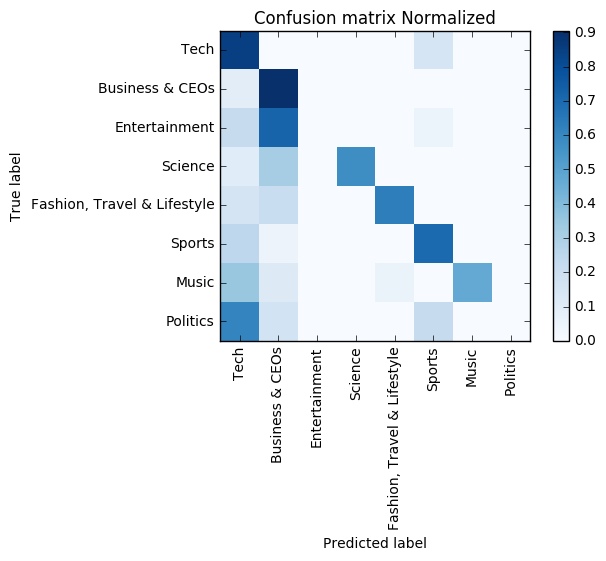

In [114]:
evaluate_prediction(predictions, test['category'])

Turned out to be pretty disappointing :( Probably word averaging doesn't work too well for tweets. This classifies most categories as "Business and CEOs" for some reason.

__Things to try__: We can tweak our preprocessing here. Probably use our previous preprocessor. Can also use a neural network based MLPClassifier instead of logistic regression.

# You can use the function below for user classification!

In [115]:
def get_tweets(handle):
    """
    Function to return user profile.
    
    Parameters:
    ----------
    handle: Twitter handle
    
    Returns:
    -------
    tweets: space seperated list of tweets
    """
    tweets = api.GetUserTimeline(screen_name=handle, count=200)
    tweets = [tweet.text for tweet in tweets]
    return ' '.join(tweets)

In [116]:
def pred_handle(handle, vectorizer=None, clf=None, g2v_or_lda=None):
    """
    Function to classify handle. Vectorizer need not be
    provided if g2v_or_lda is being used. g2v_or_lda can be:
        'g2v' for classification with glove word averaging
        'lda' for classification with LDA inference
        'None' for classification with standard preprocessor and vectorizer
    
    Parameters:
    ----------
    handle: Twitter handle of user to classify
    vectorizer: Vectorizer (pre-trained) to be used
    clf: Classifier (pre-trained) to be used
    g2v_or_lda: 'g2v', 'lda' or 'None' depending on which "mode" you want to use
    
    Returns:
    -------
    category: Classified category
    """
    if clf is None:
        raise Exception('Classifier has to be provided')
    if vectorizer is None and g2v_or_lda is None:
        raise Exception('Vectorizer should be provided if glove'
                        ' or LDA classification is not being used')
    profile = get_tweets(handle)
    if g2v_or_lda is None:
        profile = preprocess_text(profile)
        profile = bigram[profile]
        features = vectorizer.transform([' '.join(profile)])
    else:
        if g2v_or_lda == 'g2v':
            profile = g2v_tokenize_tweet(profile)
            features = word_averaging_list(wv, profile)
        elif g2v_or_lda == 'lda':
            features = np.zeros(shape=(1, num_topics))
            inference = lda_hdp[dictionary.doc2bow(message)]
            for tid, val in inference:
                features[:, tid] = val
    category = clf.predict(features)
    return category

In [121]:
try:
    pred = pred_handle('chelseafc', vectorizer=count_vectorizer, clf=clf_count, g2v_or_lda=None)[0]
except:
    print("Please check whether python-twitter is installed. If yes, please check"
          " whether credentials are stored correctly.")
print categories_map[pred]

Sports


__Please note that the results for these techniques apply to this particular dataset only__

GloVe and word embeddings are a very powerful technique to do complex NLP tasks. Do watch [this](https://www.youtube.com/watch?v=vkfXBGnDplQ) video by Chris Moody to see some of the applications of word2vec outside of text processing.

You can try other techniques too such as Doc2Vec, word mover's distance (WMD) etc. for exploring more techniques to working with text data. Do check out [this](https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb) notebook by Lev Konstantinovskiy.

# Bibliography
Do have a look at the following resources I used for making this tutorial:
- [Movie plots by genre by Lev Konstantinovskiy](https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb)
- [Topic coherence pipeline paper by Roeder et al](svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf)
- [Original LDA paper by Blei et al](https://www.cs.princeton.edu/~blei/papers/BleiNgJordan2003.pdf)
- [Online LDA paper by Blei et al](https://www.cs.princeton.edu/~blei/papers/HoffmanBleiBach2010b.pdf)
- [Empirical study of topic modeling in Twitter by Davison et al](http://snap.stanford.edu/soma2010/papers/soma2010_12.pdf)
- [Machine learning approach to twitter user classification by Pennacchiotti et al](https://www.google.co.in/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=0ahUKEwjHiN7E8svPAhUKPo8KHaY3CsUQFggiMAA&url=https%3A%2F%2Fwww.aaai.org%2Focs%2Findex.php%2FICWSM%2FICWSM11%2Fpaper%2Fdownload%2F2886%2F3262&usg=AFQjCNE7NxTUl11QpN6GA7qj6_NNK0tjqw&sig2=LXSszb8tQN00sej6yr-I5w)
- [Stanford GloVe project](http://nlp.stanford.edu/projects/glove/)